<a href="https://colab.research.google.com/github/WelfLowe/ML4developers/blob/main/1%E2%80%93Data_and_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading and checking the Iris datasets

Import necessary libraries.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score

from itertools import cycle

Load Iris dataset and convert it into a $\verb|numpy|$ array.

In [2]:
iris = load_iris()
print(iris.data.shape)
print(iris.target.shape)
print(iris.feature_names)

(150, 4)
(150,)
['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


Convert it to a $\verb|pandas|$ dataframe.

In [3]:
iris_df = pd.DataFrame(data= np.c_[iris['data'], iris['target']],columns= iris['feature_names'] + ['species'])
iris_df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2.0
146,6.3,2.5,5.0,1.9,2.0
147,6.5,3.0,5.2,2.0,2.0
148,6.2,3.4,5.4,2.3,2.0


Seperate the three classes.

In [4]:
def filter_by_species(species_id, verbose):
  s =  iris_df['species']==species_id
  s = iris_df[s]
  s = s.drop('species', axis=1)
  if verbose:
    print(s.head())
  return s

In [5]:
setosa = filter_by_species(0.0, True)
versicolor = filter_by_species(1.0, False)
virginica = filter_by_species(2.0, False)

   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0                5.1               3.5                1.4               0.2
1                4.9               3.0                1.4               0.2
2                4.7               3.2                1.3               0.2
3                4.6               3.1                1.5               0.2
4                5.0               3.6                1.4               0.2


Boxplots of the feature values of the different species.

<Axes: >

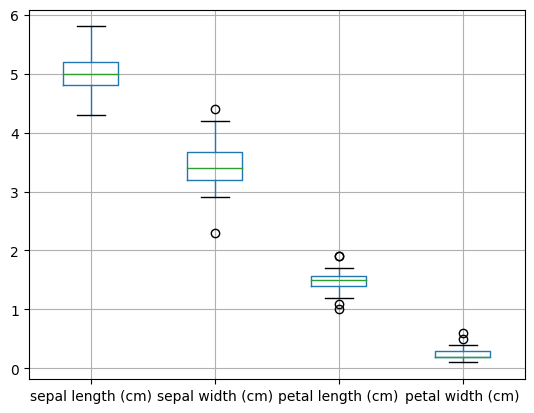

In [6]:
setosa.boxplot()

<Axes: >

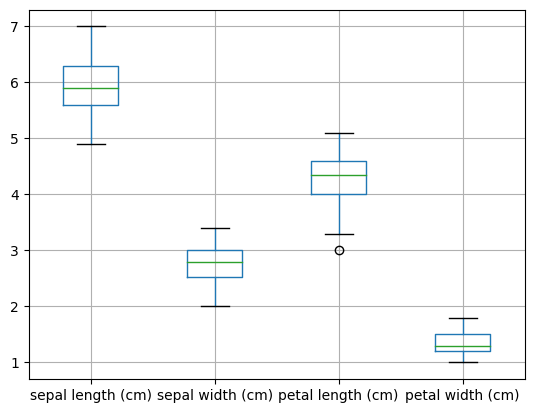

In [7]:
versicolor.boxplot()

<Axes: >

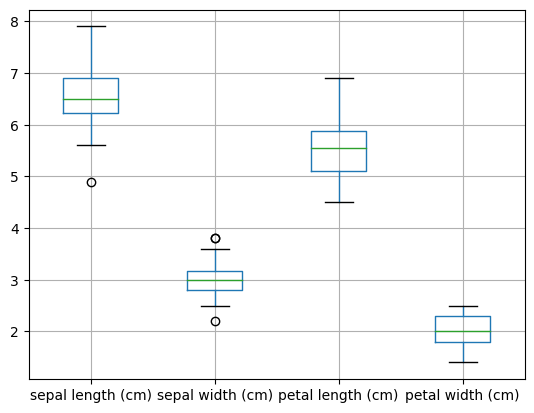

In [8]:
virginica.boxplot()

## Advanced: Training a classifier based on Iris data and assessing its quality

**OBS!** This part will not be detailed in the lectures, but might become relevant for the classification assignement. For details, refer to the [scikit-learn user manual](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html) where the code was adopted from.

Train a one-vs-rest classifier based on a logistic regression classifier and compute the (so called micro) average Receiver Operating characteristic (ROC) curve and the area under ROC (AUC). For the concept of RUC/AUC in the binary classification case, check [Google's fundational course](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc) on the topic. For the multi-class case, refer to the [scikit-learn user manual](https://scikit-learn.org/stable/modules/model_evaluation.html#roc-metrics).

In [9]:
X = iris.data
y = iris.target

# Binarize the output: for each data point and each 3 classes [0, 1, 2],
# set y to the corresponding binary array: 0->[1,0,0] 1->[0,1,0] 2->[0,0,1]
# also refered to as one-hot-encoding
y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]

# Shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

# Create a classifier to predict each class against all others using logistic regression
classifier = OneVsRestClassifier(
    # Choose an anternative classifier here
    LogisticRegression(solver="liblinear")
)
# Learn to predict each class against all others (fit)
# Then predict confidence scores for the test data (decision_function)
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

Plot the average ROC curve.

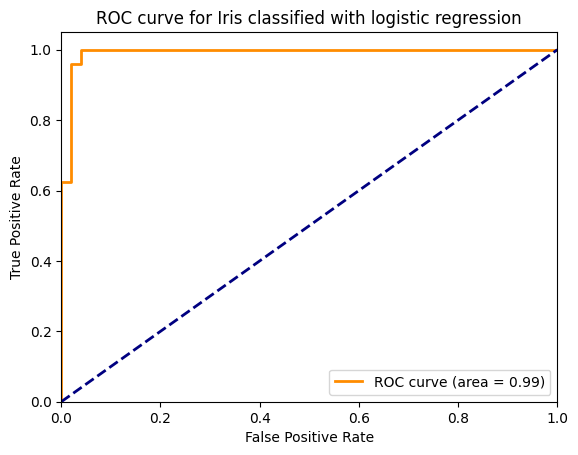

In [10]:
plt.figure()
mylinewidth = 2
plt.plot(
    fpr[2],
    tpr[2],
    color="darkorange",
    lw=mylinewidth,
    label="ROC curve (area = %0.2f)" % roc_auc[2],
)
plt.plot([0, 1], [0, 1], color="navy", lw=mylinewidth, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve for Iris classified with logistic regression")
plt.legend(loc="lower right")
plt.show()

Plot ROC curves for each label.

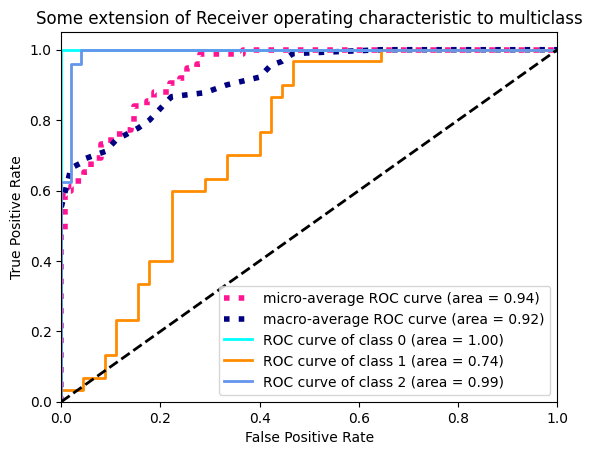

In [11]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at these points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=mylinewidth,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=mylinewidth)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()